# Learning a shortest-path proxy

## Data set definition

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.utils.graph import graph_shortest_path
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

n_points = 5000

#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
X, color = datasets.samples_generator.make_swiss_roll(n_points, random_state=0, noise=0.7)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0., 1.))
X = min_max_scaler.fit_transform(X)

fig = plt.figure(figsize=(15, 15), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.title("Learning shortest path prediction with %i points" % (n_points), fontsize=14)
plt.show()


<Figure size 2250x2250 with 1 Axes>

## Shortest-path calculation between all points

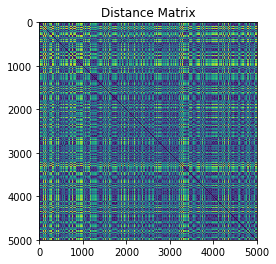

In [2]:
n_neighbors = 10
n_components = 2

class Geodesic():

    def __init__(self, n_neighbors=5, path_method='auto',
                 neighbors_algorithm='auto', n_jobs=None):
        self.n_neighbors = n_neighbors
        self.path_method = path_method
        self.neighbors_algorithm = neighbors_algorithm
        self.n_jobs = n_jobs

    def get_distance_matrix(self, X):
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors,
                                      algorithm=self.neighbors_algorithm,
                                      n_jobs=self.n_jobs)
        nbrs.fit(X)

        kng = kneighbors_graph(nbrs, self.n_neighbors,
                               mode='distance', n_jobs=self.n_jobs)
        G = graph_shortest_path(kng,
                                 method=self.path_method,
                                 directed=False)

        return G, kng, nbrs

G, _, _ = Geodesic().get_distance_matrix(X)
G = np.abs(G)

plt.imshow(np.abs(G) / np.max(np.abs(G)))
plt.title("Distance Matrix")
plt.show()

## Data set definition for learning

In [3]:
X_set = []
Y_set = []

def get_training_sample(x_1, x_2):
    #return np.concatenate((x_1, x_2, x_1 - x_2, x_2 - x_1, np.linalg.norm(x_1 - x_2, keepdims=True)), axis=0)
    return np.concatenate((x_1, x_2), axis=0)

for x_1, idx_1 in zip(X, range(len(X))):
    for x_2, idx_2 in zip(X[idx_1:], range(idx_1, len(X))):
        X_set.append(get_training_sample(x_1, x_2))
        Y_set.append(G[idx_2, idx_1])

X_set = np.asarray(X_set)
X_set = X_set.reshape((len(X_set), np.prod(X_set.shape[1:])))
Y_set = np.asarray(Y_set)[:,np.newaxis]

# double the data set by mirroring

X_set = np.concatenate((X_set, np.concatenate((X_set[:,:3],X_set[:,3:]), axis = 1)), axis = 0)
Y_set = np.concatenate((Y_set, Y_set), axis = 0)

X_train, X_test, Y_train, Y_test = train_test_split(X_set, Y_set, test_size=0.1, random_state=0)

print("Shape (X_set, Y_set)", (X_set.shape, Y_set.shape))
print("Shape (X_train, Y_train)", (X_train.shape, Y_train.shape))
print("Shape (X_test, Y_test)", (X_test.shape, Y_test.shape))

Shape (X_set, Y_set) ((25005000, 6), (25005000, 1))
Shape (X_train, Y_train) ((22504500, 6), (22504500, 1))
Shape (X_test, Y_test) ((2500500, 6), (2500500, 1))


## Learn the proxy

In [4]:

from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

# train the model
epochs, batch_size = 25, 1024

inputs = Input(shape=(X_set.shape[-1],))
h = Dense(64, activation='elu')(inputs)
#h = Dropout(0.5)(h)
h = Dense(64, activation='elu')(h)
#h = Dropout(0.5)(h)
#h = Dense(64, activation='elu')(h)
#h = Dropout(0.5)(h)
predictions = Dense(1, activation='relu')(h)
model = Model(inputs=inputs, outputs=predictions)

# Compile model
# mean_absolute_error, mean_absolute_percentage_error ,mean_squared_error, mean_squared_logarithmic_error, squared_hinge, hinge
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False))
model.fit(X_train, Y_train, verbose=2, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))



Using TensorFlow backend.



Train on 22504500 samples, validate on 2500500 samples
Epoch 1/25
 - 44s - loss: 0.3425 - val_loss: 0.1916
Epoch 2/25
 - 44s - loss: 0.1684 - val_loss: 0.1613
Epoch 3/25
 - 44s - loss: 0.1558 - val_loss: 0.1609
Epoch 4/25
 - 44s - loss: 0.1485 - val_loss: 0.1505
Epoch 5/25
 - 44s - loss: 0.1426 - val_loss: 0.1392
Epoch 6/25
 - 44s - loss: 0.1371 - val_loss: 0.1686
Epoch 7/25
 - 44s - loss: 0.1316 - val_loss: 0.1272
Epoch 8/25
 - 45s - loss: 0.1265 - val_loss: 0.1275
Epoch 9/25
 - 44s - loss: 0.1221 - val_loss: 0.1283
Epoch 10/25
 - 43s - loss: 0.1183 - val_loss: 0.1610
Epoch 11/25
 - 44s - loss: 0.1144 - val_loss: 0.1184
Epoch 12/25
 - 44s - loss: 0.1112 - val_loss: 0.1662
Epoch 13/25
 - 44s - loss: 0.1078 - val_loss: 0.1244
Epoch 14/25
 - 43s - loss: 0.1044 - val_loss: 0.1000
Epoch 15/25
 - 44s - loss: 0.1011 - val_loss: 0.1003
Epoch 16/25
 - 44s - loss: 0.0981 - val_loss: 0.1120
Epoch 17/25
 - 44s - loss: 0.0952 - val_loss: 0.1008
Epoch 18/25
 - 43s - loss: 0.0925 - val_loss: 0.1017

## Show the distribution of predicted distances

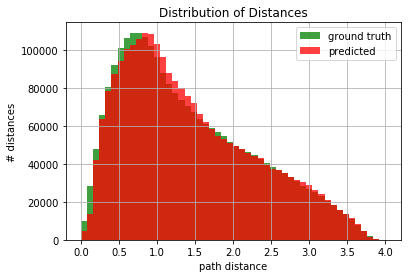

In [5]:
Y_pred = model.predict(X_test)
min_max = (np.concatenate((Y_test,Y_pred)).min(), np.concatenate((Y_test,Y_pred)).max())
plt.hist(Y_test, 50, range=min_max, density=False, facecolor='g', alpha=0.75)
plt.hist(Y_pred, 50, range=min_max, density=False, facecolor='r', alpha=0.75)

plt.xlabel('path distance')
plt.ylabel('# distances')
plt.legend(["ground truth", "predicted"])
plt.title('Distribution of Distances')
plt.grid(True)
plt.show()

## Pick a point and show the predicted distance to every other point

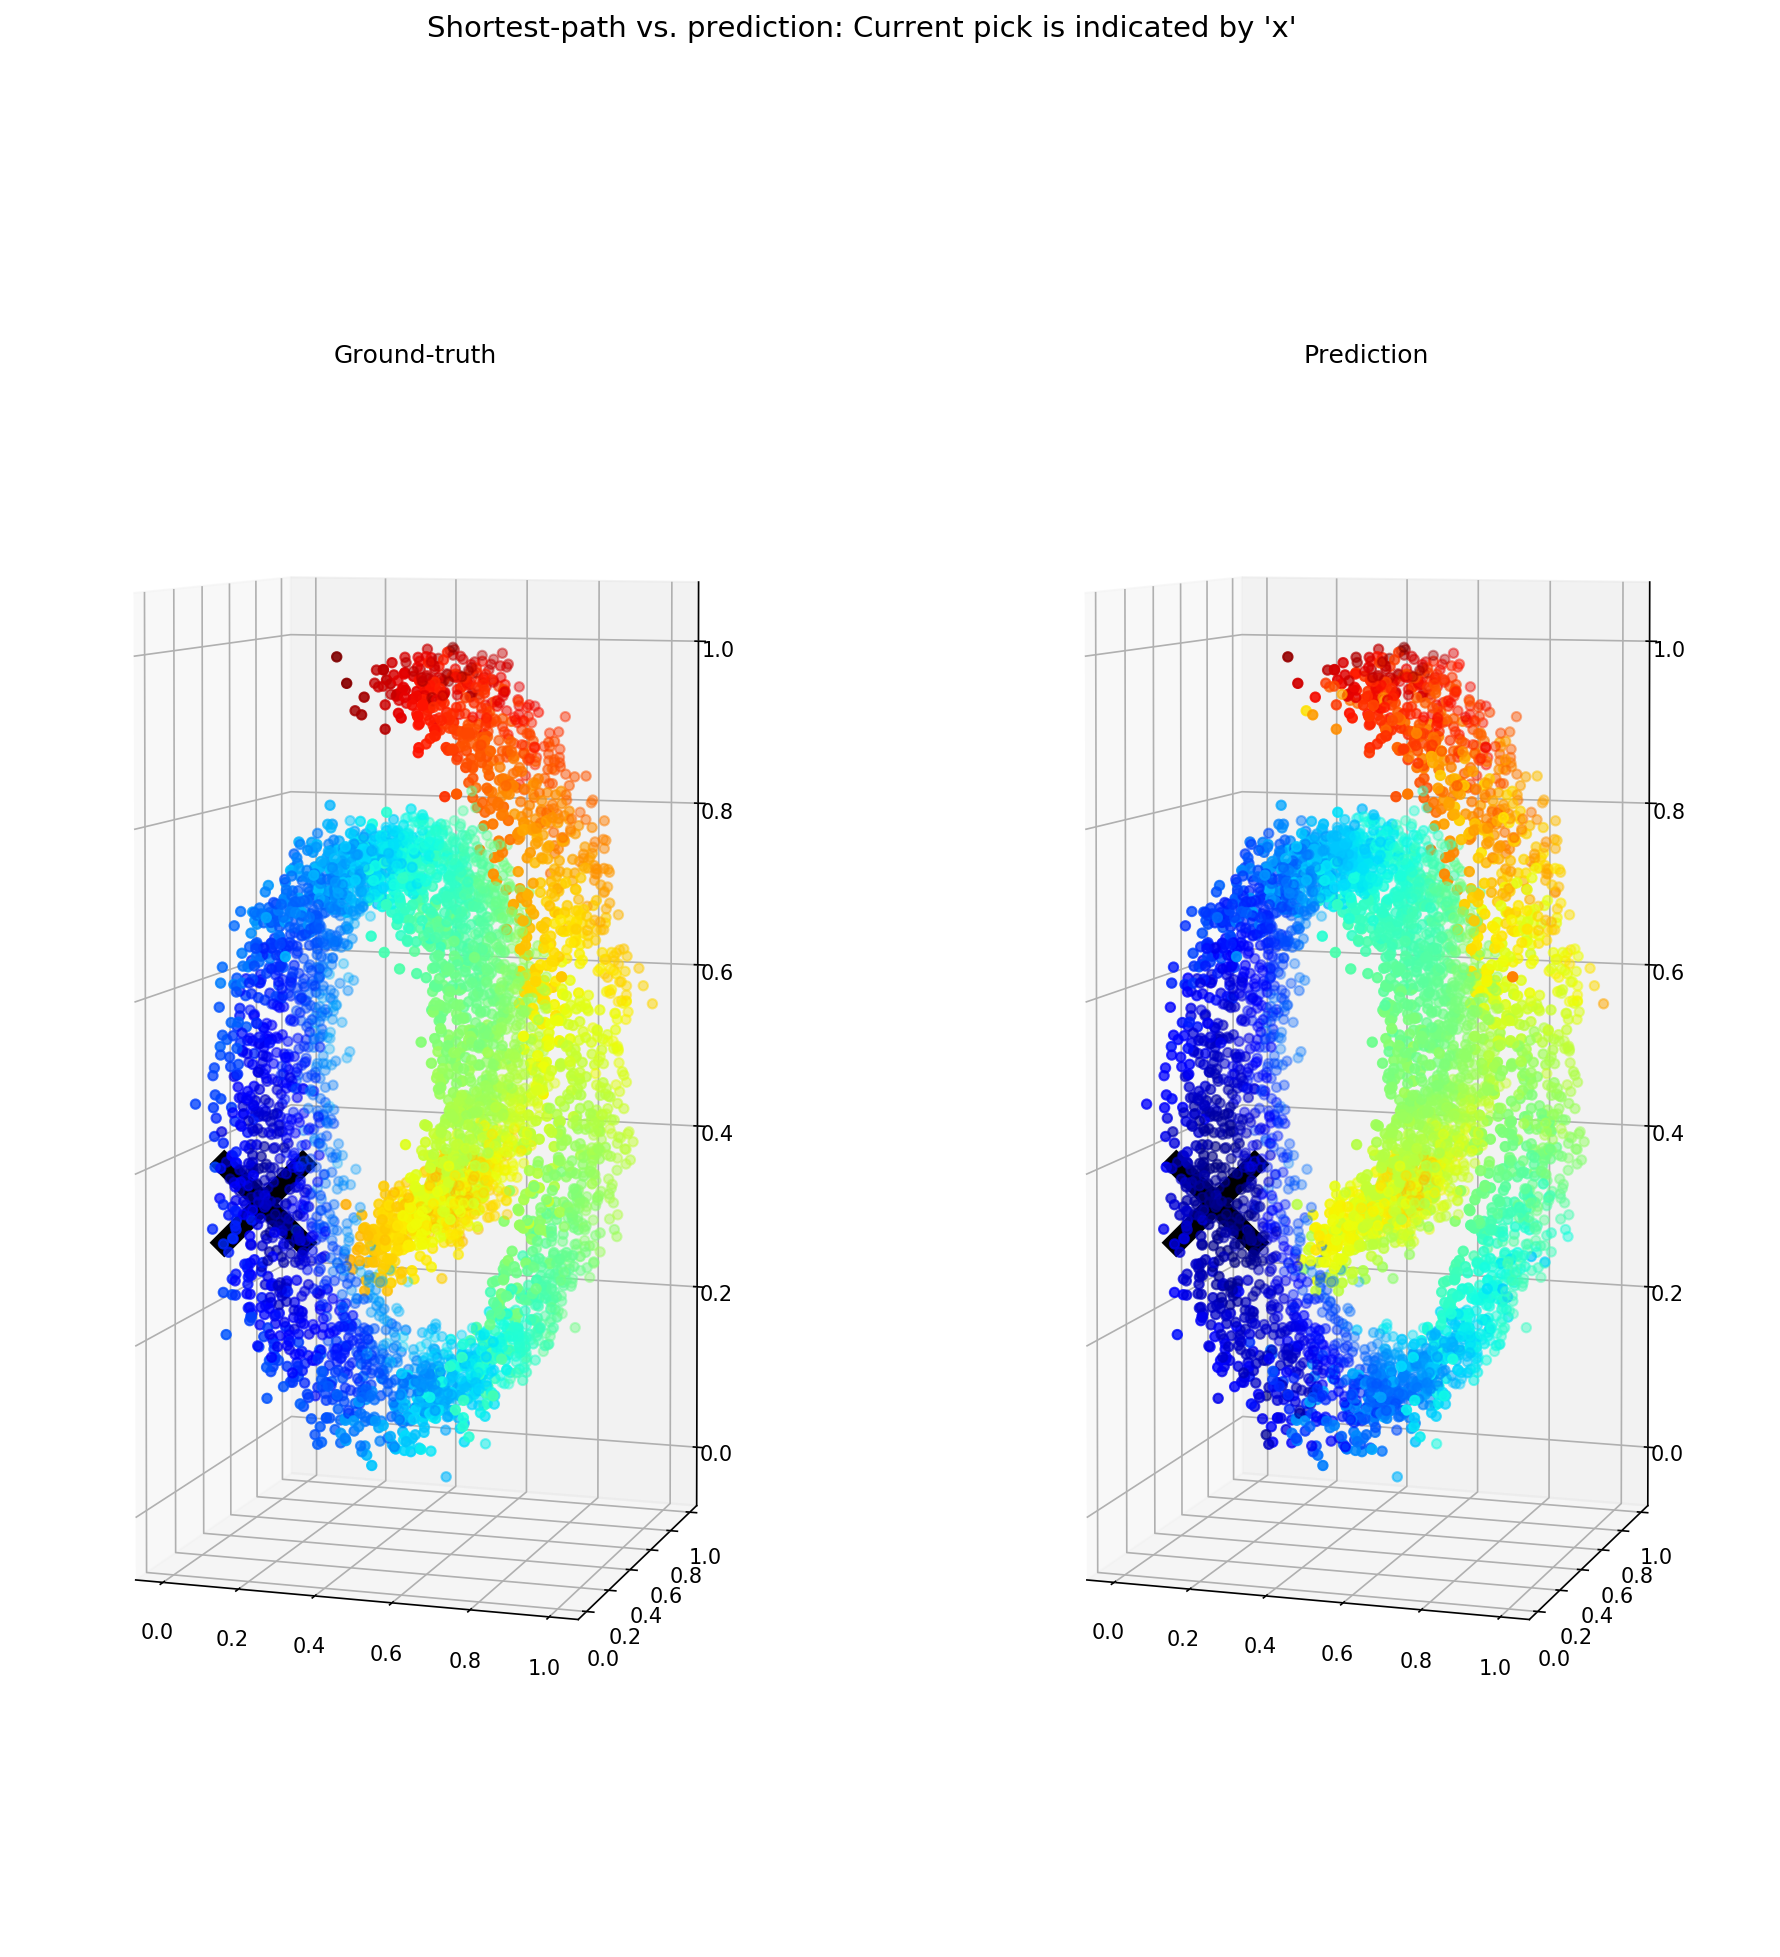

In [6]:
pick = 0
X_viz = []
for x in X:
    X_viz.append(get_training_sample(X[pick], x))
X_viz = np.asarray(X_viz)
X_viz = X_viz.reshape((len(X_viz), np.prod(X_viz.shape[1:])))

fig = plt.figure(figsize=(15, 15), dpi=150)
plt.suptitle("Shortest-path vs. prediction: Current pick is indicated by 'x'", fontsize=14)

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=G[pick]/G[pick].max(), cmap=plt.cm.jet)
ax.scatter(X[pick, 0], X[pick, 1], X[pick, 2], s=2000, linewidth=10, marker='x', c=[0.0], cmap=plt.cm.gray)
ax.view_init(4, -72)
ax.set_title("Ground-truth")
ax = fig.add_subplot(122, projection='3d')
Y_viz = model.predict(X_viz)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.squeeze(Y_viz/Y_viz.max()), cmap=plt.cm.jet)
ax.scatter(X[pick, 0], X[pick, 1], X[pick, 2], s=2000, linewidth=10, marker='x', c=[0.0], cmap=plt.cm.gray)
ax.view_init(4, -72)
ax.set_title("Prediction")
plt.show()

## Store the model

In [7]:
print("Store model")
model.save('models/shortest_path_predictor_0to1.h5')

Store model
